In [1]:
import sys
import os
import math
import numpy as np
import torch
sys.path.append(os.path.abspath(os.path.join(os.path.dirname("ide"), '../..')))
#sys.path.append(os.path.abspath(os.path.join(os.path.dirname("deep_feature_reweighting"), '../..')))

In [2]:
#ckpt = torch.load("F:/model_stuff/r90e20 wb/checkpoint-best.pth", map_location=torch.device('cpu'))['model']
ckpt = torch.load("/home/primmere/ide/external/wdpruning/logs/wb/r90e50val/checkpoint-best.pth", map_location=torch.device('cuda'),weights_only=False)['model']

In [3]:
from external.wdpruning.vit_wdpruning import VisionTransformerWithWDPruning

model = VisionTransformerWithWDPruning(num_classes=2,
                                       patch_size=16, embed_dim=768,
                                       depth=12, num_heads=12, mlp_ratio=4,
                                       head_pruning=True, fc_pruning=True)

model2 = VisionTransformerWithWDPruning(num_classes=2,
                                       patch_size=16, embed_dim=768,
                                       depth=12, num_heads=12, mlp_ratio=4,
                                       head_pruning=True, fc_pruning=True)

using stride: 16, and patch number is num_y14 * num_x14
using drop_out rate is : 0.0
using attn_drop_out rate is : 0.0
using drop_path rate is : 0.1
using stride: 16, and patch number is num_y14 * num_x14
using drop_out rate is : 0.0
using attn_drop_out rate is : 0.0
using drop_path rate is : 0.1


In [4]:
model.load_state_dict(ckpt, strict=False)
model2.load_state_dict(ckpt, strict=False)

_IncompatibleKeys(missing_keys=[], unexpected_keys=['norm_classifier.2.weight', 'norm_classifier.2.bias', 'head_classifier.2.weight', 'head_classifier.2.bias'])

In [5]:
def count_parameters(model):
    params = sum(p.numel() for n,p in model.named_parameters() if p.requires_grad and 'blocks' in n)
    return params

In [6]:
model._make_structural_pruning()


In [7]:
pre = count_parameters(model2)
post = count_parameters(model)
print(pre)
print(post)
print(post/pre)

85109952
85054464
0.9993480433404545


In [27]:
for name, param in model.named_parameters():
    for name2, param2 in model2.named_parameters():
        if name == name2:
            if param.size()!=param2.size():
                print(name)
                print(param.size())
                print(param2.size())
        #print(param)
print("done")

done


In [10]:
for name, param in model2.named_parameters():
    if param.requires_grad and 'blocks' in name and "attn.qkv.head_saliency_scores" in name:
        print(name)
        print(param.size())
        print(param)

blocks.0.attn.qkv.head_saliency_scores
torch.Size([12, 1])
Parameter containing:
tensor([[ 0.0034],
        [ 0.0059],
        [ 0.0008],
        [ 0.0029],
        [ 0.0018],
        [-0.0035],
        [ 0.0030],
        [ 0.0019],
        [-0.0029],
        [ 0.0011],
        [ 0.0004],
        [-0.0012]], requires_grad=True)
blocks.1.attn.qkv.head_saliency_scores
torch.Size([12, 1])
Parameter containing:
tensor([[ 2.3251e-04],
        [-3.3665e-04],
        [ 9.3405e-04],
        [-9.7161e-04],
        [ 5.6230e-04],
        [ 5.4293e-03],
        [-6.7269e-04],
        [-2.6583e-03],
        [-2.3133e-06],
        [-5.8304e-04],
        [ 6.5214e-03],
        [-8.2193e-04]], requires_grad=True)
blocks.2.attn.qkv.head_saliency_scores
torch.Size([12, 1])
Parameter containing:
tensor([[ 1.5943e-03],
        [-1.5297e-03],
        [ 8.1663e-05],
        [ 1.1283e-04],
        [-1.4587e-03],
        [ 8.5676e-03],
        [-7.6784e-05],
        [ 6.7360e-03],
        [ 1.0695e-04],
    

In [11]:
total_params = 0
for name, param in model2.named_parameters():
    if param.requires_grad and 'blocks' in name and "head" in name:
        print(name)
        print(param.size())
        print(param)

blocks.0.attn.qkv.head_saliency_scores
torch.Size([12, 1])
Parameter containing:
tensor([[ 0.0034],
        [ 0.0059],
        [ 0.0008],
        [ 0.0029],
        [ 0.0018],
        [-0.0035],
        [ 0.0030],
        [ 0.0019],
        [-0.0029],
        [ 0.0011],
        [ 0.0004],
        [-0.0012]], requires_grad=True)
blocks.0.attn.qkv.threshold_head
torch.Size([1])
Parameter containing:
tensor([10.0939], requires_grad=True)
blocks.1.attn.qkv.head_saliency_scores
torch.Size([12, 1])
Parameter containing:
tensor([[ 2.3251e-04],
        [-3.3665e-04],
        [ 9.3405e-04],
        [-9.7161e-04],
        [ 5.6230e-04],
        [ 5.4293e-03],
        [-6.7269e-04],
        [-2.6583e-03],
        [-2.3133e-06],
        [-5.8304e-04],
        [ 6.5214e-03],
        [-8.2193e-04]], requires_grad=True)
blocks.1.attn.qkv.threshold_head
torch.Size([1])
Parameter containing:
tensor([9.9970], requires_grad=True)
blocks.2.attn.qkv.head_saliency_scores
torch.Size([12, 1])
Parameter contai

In [12]:
model.blocks[10].attn.qkv.weight.shape

torch.Size([2304, 768])

In [13]:
from pruner.modules.binarizer import TopKBinarizer

In [14]:
i = 10
sal_scores = model2.blocks[i].attn.qkv.head_saliency_scores
print(sal_scores)
t = model2.blocks[i].attn.qkv.threshold_head
print(t)
print(torch.sigmoid(t).item())
mask_head = TopKBinarizer.apply(sal_scores, t, -1)
print(mask_head)

Parameter containing:
tensor([[-1.7363e-03],
        [-3.9436e-04],
        [ 1.1396e-03],
        [-1.1635e-05],
        [-9.7784e-05],
        [-8.5902e-04],
        [ 1.4761e-03],
        [ 2.0507e-03],
        [ 2.7272e-03],
        [ 6.0748e-04],
        [ 1.8104e-03],
        [-7.0468e-04]], requires_grad=True)
Parameter containing:
tensor([9.9954], requires_grad=True)
0.999954342842102
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], grad_fn=<TopKBinarizerBackward>)


In [15]:
for i in range(12):
    sal_scores = model2.blocks[i].attn.qkv.head_saliency_scores
    #print(sal_scores)
    t = model2.blocks[i].attn.qkv.threshold_head
    #print(t)
    print(torch.sigmoid(t).item())
    mask_head = TopKBinarizer.apply(sal_scores, t, -1)
    #print(mask_head)

0.9999586343765259
0.9999544620513916
0.9999568462371826
0.9999555349349976
0.9999585151672363
0.9999570846557617
0.9999570846557617
0.9999573230743408
0.9999557733535767
0.9999556541442871
0.999954342842102
0.9999535083770752


In [16]:
for i in range(12):
    sal_scores = model2.blocks[i].attn.proj.saliency_scores
    #print(sal_scores)
    t = model2.blocks[i].attn.proj.threshold_fc
    #print(t)
    print(torch.sigmoid(t).item())
    mask_head = TopKBinarizer.apply(sal_scores, t, -1)
    print(torch.nonzero(mask_head == 0, as_tuple=False))


0.9999580383300781
tensor([], size=(0, 2), dtype=torch.int64)
0.9999561309814453
tensor([], size=(0, 2), dtype=torch.int64)
0.9999580383300781
tensor([], size=(0, 2), dtype=torch.int64)
0.9999566078186035
tensor([], size=(0, 2), dtype=torch.int64)
0.9999563694000244
tensor([], size=(0, 2), dtype=torch.int64)
0.9999569654464722
tensor([], size=(0, 2), dtype=torch.int64)
0.9999570846557617
tensor([], size=(0, 2), dtype=torch.int64)
0.9999570846557617
tensor([], size=(0, 2), dtype=torch.int64)
0.9999539852142334
tensor([], size=(0, 2), dtype=torch.int64)
0.9999549388885498
tensor([], size=(0, 2), dtype=torch.int64)
0.9999544620513916
tensor([], size=(0, 2), dtype=torch.int64)
0.9999531507492065
tensor([], size=(0, 2), dtype=torch.int64)


In [17]:
for name, param in model2.named_parameters():
    if param.requires_grad and 'blocks' in name and ("saliency") in name:
        print(name)
        print(param.size())
        #print(param)

blocks.0.attn.qkv.head_saliency_scores
torch.Size([12, 1])
blocks.0.attn.proj.saliency_scores
torch.Size([768, 1])
blocks.0.mlp.fc1.saliency_scores
torch.Size([3072, 1])
blocks.0.mlp.fc2.saliency_scores
torch.Size([768, 1])
blocks.1.attn.qkv.head_saliency_scores
torch.Size([12, 1])
blocks.1.attn.proj.saliency_scores
torch.Size([768, 1])
blocks.1.mlp.fc1.saliency_scores
torch.Size([3072, 1])
blocks.1.mlp.fc2.saliency_scores
torch.Size([768, 1])
blocks.2.attn.qkv.head_saliency_scores
torch.Size([12, 1])
blocks.2.attn.proj.saliency_scores
torch.Size([768, 1])
blocks.2.mlp.fc1.saliency_scores
torch.Size([3072, 1])
blocks.2.mlp.fc2.saliency_scores
torch.Size([768, 1])
blocks.3.attn.qkv.head_saliency_scores
torch.Size([12, 1])
blocks.3.attn.proj.saliency_scores
torch.Size([768, 1])
blocks.3.mlp.fc1.saliency_scores
torch.Size([3072, 1])
blocks.3.mlp.fc2.saliency_scores
torch.Size([768, 1])
blocks.4.attn.qkv.head_saliency_scores
torch.Size([12, 1])
blocks.4.attn.proj.saliency_scores
torch.Size

In [18]:
ratios = np.zeros((12,4), dtype=np.float32)

for i in range(12):
    proj_thr = torch.sigmoid(model2.blocks[i].attn.proj.threshold_fc).item()
    proj_numel = model2.blocks[i].attn.proj.saliency_scores.numel() 
    attn_proj_r = 1 - math.ceil(proj_thr * proj_numel) / proj_numel 
    
    fc1_thr = torch.sigmoid(model2.blocks[i].mlp.fc1.threshold_fc).item()
    fc1_numel = model2.blocks[i].mlp.fc1.saliency_scores.numel()      
    fc1_r = 1 - math.ceil(fc1_thr * fc1_numel) / fc1_numel
    
    fc2_thr = torch.sigmoid(model2.blocks[i].mlp.fc2.threshold_fc).item()
    fc2_numel = model2.blocks[i].mlp.fc2.saliency_scores.numel()           
    fc2_r = 1 - math.ceil(fc2_thr * fc2_numel) / fc2_numel
    
    attn_sal = model2.blocks[i].attn.qkv.head_saliency_scores
    attn_t = torch.sigmoid(model2.blocks[i].attn.qkv.threshold_head).item()
    attn_r = 1 - math.ceil(attn_t*attn_sal.numel())/attn_sal.numel()
    print(attn_r, attn_proj_r, fc1_r, fc2_r, )

    ratios[i] = [attn_r, attn_proj_r, fc1_r, fc2_r, ]
    
print(ratios)


0.0 0.0 0.0 0.0
0.0 0.0 0.0 0.0
0.0 0.0 0.0 0.0
0.0 0.0 0.0 0.0
0.0 0.0 0.0 0.0
0.0 0.0 0.0 0.0
0.0 0.0 0.0 0.0
0.0 0.0 0.0 0.0
0.0 0.0 0.0 0.0
0.0 0.0 0.0 0.0
0.0 0.0 0.0 0.0
0.0 0.0 0.0 0.0
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


In [19]:
import matplotlib.pyplot as plt

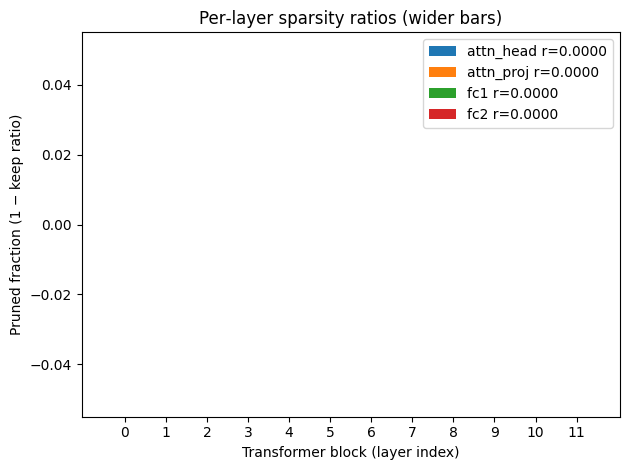

In [20]:
n_layers = ratios.shape[0]              # 12
avgs = np.sum(ratios, axis=0)/n_layers

bar_width = 0.23                   # wider bars
x = np.arange(n_layers)                 # layer centers

labels = [
    f"attn_head r={avgs[0]:.4f}",
    f"attn_proj r={avgs[1]:.4f}",
    f"fc1 r={avgs[2]:.4f}",
    f"fc2 r={avgs[3]:.4f}",
]
# Center the 4 bars around each x position
offsets = (np.arange(ratios.shape[1]) - (ratios.shape[1] - 1) / 2) * bar_width

for j, offset in enumerate(offsets):
    plt.bar(x + offset, ratios[:, j], width=bar_width, label=labels[j])

plt.xlabel("Transformer block (layer index)")
plt.ylabel("Pruned fraction (1 − keep ratio)")
plt.title("Per‑layer sparsity ratios (wider bars)")
plt.xticks(x, [str(i) for i in range(n_layers)])
plt.legend()
plt.tight_layout()
plt.show()

In [21]:
a = np.array([[1,2,3],[4,5,6]])
print(a)
print(a.shape)
print(np.sum(a,axis=0)/2)

[[1 2 3]
 [4 5 6]]
(2, 3)
[2.5 3.5 4.5]


In [28]:
from collections import defaultdict

def get_block_params(model, trainable_only=True):
    """Return a dict name ➜ tensor for parameters in 'blocks'."""
    return {
        n: p
        for n, p in model.named_parameters()
        if 'blocks' in n and (p.requires_grad or not trainable_only)
    }

m1 = get_block_params(model)      # post
m2 = get_block_params(model2)     # pre

# 1. Names present in one model but not the other
only_in_m1 = m1.keys() - m2.keys()
only_in_m2 = m2.keys() - m1.keys()

# 2. Shapes differ
shape_mismatch = {
    n: (m1[n].shape, m2[n].shape)
    for n in m1.keys() & m2.keys()
    if m1[n].shape != m2[n].shape
}

# 3. Same tensor but requires_grad differs
grad_flag_diff = {
    n: (m1[n].requires_grad, m2[n].requires_grad)
    for n in (set(get_block_params(model, False)) |
              set(get_block_params(model2, False)))
    if ('blocks' in n and
        m1.get(n, None) is not None and
        m2.get(n, None) is not None and
        m1[n].requires_grad != m2[n].requires_grad)
}

# --- report ------------------------------------------------------------
if only_in_m1:
    print("Present only in model (post):")
    for n in sorted(only_in_m1):
        print(f"  {n}  →  shape {m1[n].shape}")

if only_in_m2:
    print("\nPresent only in model2 (pre):")
    for n in sorted(only_in_m2):
        print(f"  {n}  →  shape {m2[n].shape}")

if shape_mismatch:
    print("\nSame name but different shape:")
    for n, (s1, s2) in shape_mismatch.items():
        print(f"  {n}: {s1} vs {s2}")

if grad_flag_diff:
    print("\nSame name/shape but requires_grad differs:")
    for n, (g1, g2) in grad_flag_diff.items():
        print(f"  {n}: model requires_grad={g1}, model2 requires_grad={g2}")

if not (only_in_m1 or only_in_m2 or shape_mismatch or grad_flag_diff):
    print("No differences in 'blocks' parameters!")



Present only in model2 (pre):
  blocks.0.attn.proj.saliency_scores  →  shape torch.Size([768, 1])
  blocks.0.attn.proj.threshold_fc  →  shape torch.Size([1])
  blocks.0.attn.qkv.head_saliency_scores  →  shape torch.Size([12, 1])
  blocks.0.attn.qkv.threshold_head  →  shape torch.Size([1])
  blocks.0.mlp.fc1.saliency_scores  →  shape torch.Size([3072, 1])
  blocks.0.mlp.fc1.threshold_fc  →  shape torch.Size([1])
  blocks.0.mlp.fc2.saliency_scores  →  shape torch.Size([768, 1])
  blocks.0.mlp.fc2.threshold_fc  →  shape torch.Size([1])
  blocks.1.attn.proj.saliency_scores  →  shape torch.Size([768, 1])
  blocks.1.attn.proj.threshold_fc  →  shape torch.Size([1])
  blocks.1.attn.qkv.head_saliency_scores  →  shape torch.Size([12, 1])
  blocks.1.attn.qkv.threshold_head  →  shape torch.Size([1])
  blocks.1.mlp.fc1.saliency_scores  →  shape torch.Size([3072, 1])
  blocks.1.mlp.fc1.threshold_fc  →  shape torch.Size([1])
  blocks.1.mlp.fc2.saliency_scores  →  shape torch.Size([768, 1])
  blocks.